# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (ie 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
# load other package
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [3]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [8]:
profile.gender.unique()

array([None, 'F', 'M', 'O'], dtype=object)

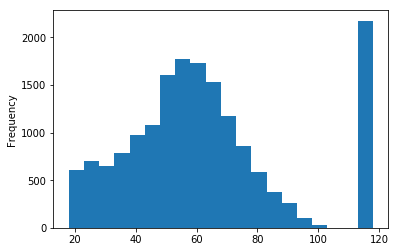

In [9]:
profile.age.plot(kind="hist", bins=20)

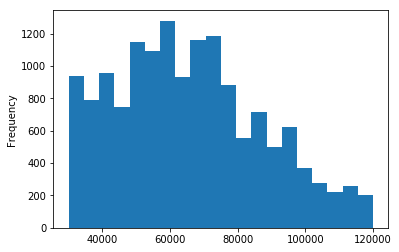

In [10]:
profile.income.plot(kind="hist", bins=20)

### Step 1: Access Data

* Portfolia data:  
    1. The attribute channels contains different channel in one cell.

* Profile data:  
    1. The attribute became_member_on is datetime type
    2. The attribute gender has None that represents a missing value. And the value O represent "ohter", the value F represent "Female", and the ohter one M represent "Male"
    3. The attribute age has abnormal value that is over 100, which maybe is the max value option

* Transcript data:  
    1. The attribute value is a dict data, which contain many information
    2. There are some duplicated values

In [11]:
# extract all channels
channels_set = set()
for i in portfolio.channels:
    channels_set.update(set(i))

In [12]:
channels_set

{'email', 'mobile', 'social', 'web'}

In [13]:
# split the channel into different attribute
for i in channels_set:
    portfolio[i] = portfolio.channels.apply(lambda x: i in x).map({True:1, False: 0})

In [14]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,social,web,mobile,email
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,0,1,1,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,0,1,0,1


In [15]:
# convert the datatype into datetime
profile["became_member_on"] = pd.to_datetime(profile.became_member_on.apply(str))

In [16]:
# parse the information about the gender
profile["gender"] = profile.gender.map({"None":np.nan, "F":"Female", "M":"Male", "O": "Other"})

In [17]:
# fix the abnormal values about the attribute age
profile.loc[profile.age == 118, "age"] = np.nan

In [18]:
profile.head()

,age,became_member_on,gender,id,income
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,2017-07-15,Female,0610b486422d4921ae7d2bf64640c50b,112000.0
2,NaN,2018-07-12,NaN,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75.0,2017-05-09,Female,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,NaN,2017-08-04,NaN,a03223e636434f42ac4c3df47e8bac43,NaN


In [19]:
# get the all kinds of the transcript type value
transcript_type = set()
for i in transcript.value:
    transcript_type.update(set(i.keys()))

In [20]:
transcript_type

{'amount', 'offer id', 'offer_id', 'reward'}

In [21]:
for i in ["amount", "reward"]:
    transcript[i] = transcript.value.apply(lambda x: x[i] if i in x else np.nan)

In [22]:
def parse_offer_id(x, option=["offer_id", "offer id"]):
    """Parse the offer id value
    The two types are same information in the transript value,
    so we use the another way to parse the information
    
    Parameters:
    -----------
    x: dict
        It is the value store in the transcript value
    option: list
        It is a list that contains the same value
    
    Results:
    ----------
    result:
        If it exists, return the value, otherwise return the nan
    """
    for i in option:
        if i in x:
            result = x[i]
            break
    else:
        result = np.nan
    
    return result

transcript["offer_id"] = transcript.value.apply(parse_offer_id)
transcript["event"] = transcript.event.map({
    "offer completed": "offer_completed", "offer received": "offer_received",
    "offer viewed":"offer_viewed"
})

In [23]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer_received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer_received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer_received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [24]:
# drop the unnessary attribute
portfolio.drop("channels", axis=1, inplace=True)
transcript.drop("value", axis=1, inplace=True)

In [25]:
# access the duplicate values
transcript.duplicated().sum(), portfolio.duplicated().sum(), profile.duplicated().sum()

(397, 0, 0)

In [26]:
transcript.drop_duplicates(inplace=True)

In [27]:
transcript.reset_index(drop=True, inplace=True)

### Step 2: Preprocess Data

* Portfolia data:  
    1. Get the different channel to store in different attribute

* Profile data:  
    1. Convert the attribute became_member_on to datetime type
    2. Transfrom the attribute gender value to the original value
    3. The attribute age abnormal value translate to missing value in temporary. According to another appendix information about the users age statistics, the main users' age is between 22 - 60, which agrees with the main distribution in the data.

* Transcript data:  
    1. Transform the attribute value into the different attribute
    2. Drop the duplicated values

Finally, we need to merge the dataset.

In [28]:
portfolio.head(2)

,difficulty,duration,id,offer_type,reward,social,web,mobile,email
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,0,1,1
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1


In [29]:
profile.head(2)

,age,became_member_on,gender,id,income
0,NaN,2017-02-12,NaN,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55.0,2017-07-15,Female,0610b486422d4921ae7d2bf64640c50b,112000.0


In [30]:
transcript.head(2)

,event,person,time,amount,reward,offer_id
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [31]:
# merge the data
data = transcript.merge(profile, how="left", left_on="person", right_on="id", validate="m:1")
data.drop("id", inplace=True, axis=1)
data = data.merge(portfolio, how="left", left_on="offer_id", right_on="id", validate="m:1",
                 suffixes=("_transcript", "_portfolia"))
data.drop("id", inplace=True, axis=1)

In [32]:
data.head(2)

,event,person,time,amount,reward_transcript,offer_id,age,became_member_on,gender,income,difficulty,duration,offer_type,reward_portfolia,social,web,mobile,email
0,offer_received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,75.0,2017-05-09,Female,100000.0,5.0,7.0,bogo,5.0,0.0,1.0,1.0,1.0
1,offer_received,a03223e636434f42ac4c3df47e8bac43,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,2017-08-04,NaN,NaN,20.0,10.0,discount,5.0,0.0,1.0,0.0,1.0


## A. Reference
1. [Starbucks Demographics and Consumer Insights](http://snapshot.numerator.com/brand/starbucks)
2. [30 Curious Starbucks Demographics](https://brandongaille.com/30-curious-starbucks-demographics/)
3. [Who Is Starbucks' Target Audience?](https://smallbusiness.chron.com/starbucks-target-audience-10553.html)